# This starts n=x (4 in this example) mpi processes using iPython's ipyparallel module

In [1]:
import ipyparallel as ipp
cluster = ipp.Cluster(engines="MPI",n=4)
cluster.start_and_connect_sync()

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

# This script (realization of aladfy_mpi.py in jupyter):
## 1. Creates an initial alanine dipeptide structure and minimizes for all processes
## 2. Distributes the calculation of dihedral restrained minimization across the processes available
## Set-up call to pyCHARMM functional libraries. This should be parallel so we will use magic %%px to denote a parallel block to run across all processors

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

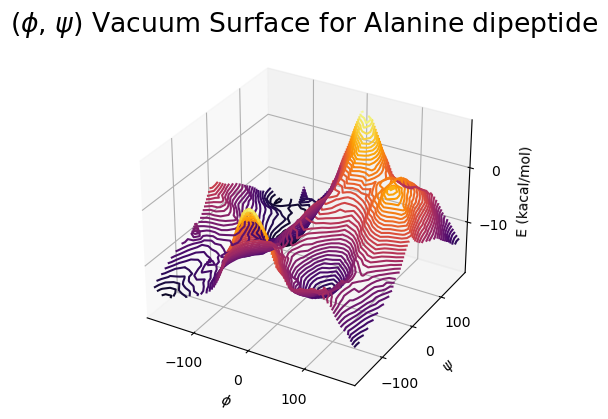

[output:0]

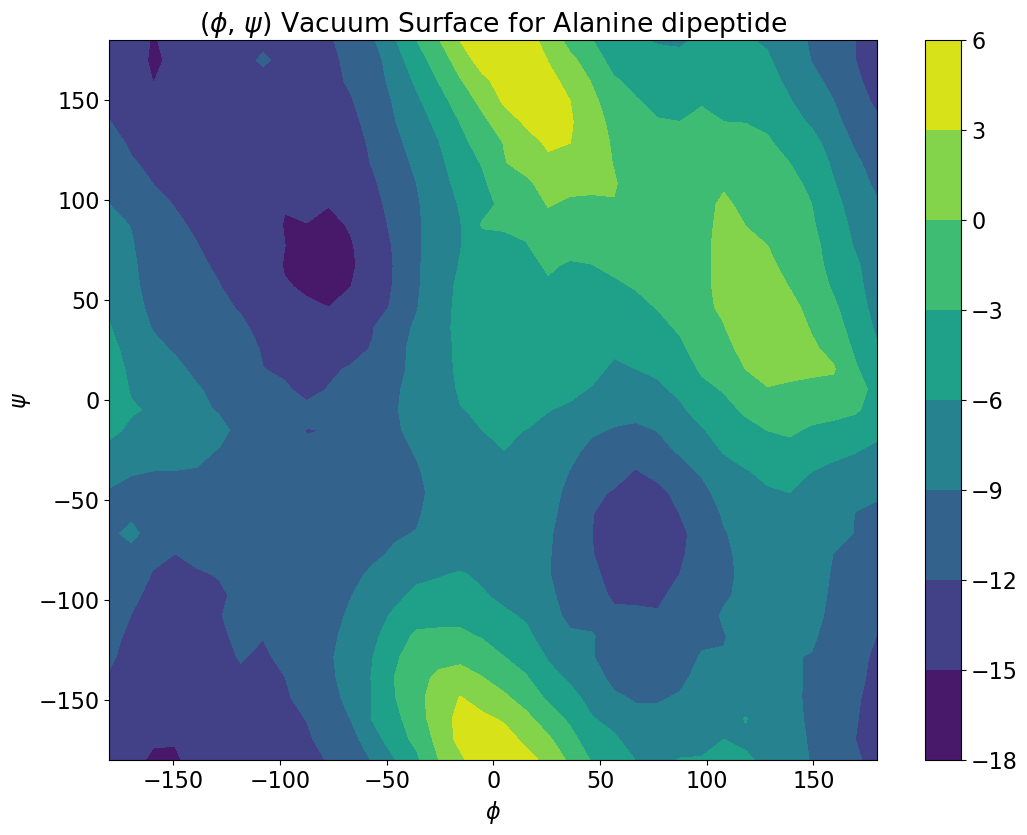

In [2]:
%%px
import os
import sys
import subprocess
import numpy as np
import pandas as pd

import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm

# We will loop over the phi/psi angles to construct the phi/psi
# surface and distribute this across processes to reduce cost using mpi
# Add in mpi support
from mpi4py import MPI
comm = MPI.COMM_WORLD
nproc = comm.Get_size()
rank = comm.Get_rank()
# Logical flag to invoke gbmv energy surface
gbmv = False
# Function to plot surfaces
#
def pltFYMap():
    import pickle
    if gbmv:
        with open('gbmv/fymap-ala_gbmv.pkl', 'rb') as fh:
            fymap = pickle.load(fh)
    else:
        with open('vacuum/fymap-ala.pkl', 'rb') as fh:
            fymap = pickle.load(fh)

    en_df = pd.DataFrame.from_dict(fymap)
    en_df.sort_values(by=['F','Y'],inplace=True)
    fymap = en_df.to_dict(orient='list')
    F = np.linspace(-180,180,36)
    Y = F
    # reshape the energy array into nxn array
    # use transpose (.T) because of loop order above
    ener = np.reshape(np.asarray(fymap['ener']),(len(F),len(Y)))
    ener = ener.T
    emax = np.max(ener)
    emin = np.min(ener)
    erange = emax - emin
    ehigh = np.ceil(emin+1.1*erange)
    elow = np.floor(emax-1.1*erange)
    F,Y=np.meshgrid(F,Y)
    # Now let's plot the data f/y map
    from mpl_toolkits.mplot3d import axes3d
    import matplotlib.pyplot as plt
    from matplotlib import cm
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    plt.rcParams.update({'font.size':16})
    # Plot the 3D surface
    ax.contour3D(F,Y,ener,50,cmap='inferno')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_zlim(elow, ehigh)
    
    if gbmv: ax.set_title('($\phi$, $\psi$) GBMV Surface for Alanine dipeptide')
    else: ax.set_title('($\phi$, $\psi$) Vacuum Surface for Alanine dipeptide')
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$\psi$')
    ax.set_zlabel('E (kacal/mol)')
    if gbmv: plt.savefig('gbmv/fysurf-ala_gbmv.pdf')    
    else: plt.savefig('vacuum/fysurf-ala.pdf')    
    plt.show()
    fig = plt.figure(figsize=(12,9))
    left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
    ax = fig.add_axes([left, bottom, width, height]) 
    cp = plt.contourf(F, Y, ener)
    plt.colorbar(cp) 
    if gbmv: ax.set_title('($\phi$, $\psi$) GBMV Surface for Alanine dipeptide')
    else: ax.set_title('($\phi$, $\psi$) Vacuum Surface for Alanine dipeptide')
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$\psi$')
    if gbmv: plt.savefig('gbmv/fycontour-ala_gbmv.pdf')
    else: plt.savefig('vacuum/fycontour-ala.pdf')
    plt.show()
    return
#####################################################################
###############PYCHARMM SCRIPTING STARTS HERE########################
# template for f/y restraints
Fcons = '1 cy 1 n 1 ca 1 c'
Ycons = '1 n 1 ca 1 c 1 nt'
settings.set_verbosity(0)
settings.set_warn_level(-5)
read.rtf('../toppar/top_all36_prot.rtf')
read.prm('../toppar/par_all36m_prot.prm')
read.sequence_string('ALA')  # ALAD for full dipeptide
gen.new_segment(seg_name='ALAD',
                first_patch='ACE', #comment to use alad residue
                last_patch='CT3',  #comment to use alad residue
                setup_ic=True)
ic.prm_fill(replace_all=True)
ic.seed(1,'CAY',1,'CY',1,'N')  
ic.build()
pycharmm.NonBondedScript(**{'cutnb': 16,
                            'ctofnb': 14,
                            'ctonnb': 12,
                            'atom': True,
                            'vatom': True,
                            'eps': 1,	
                            'switch': True,
                            'vswitch': True,
                            'cdie': True}).run()

minimize.run_abnr(**{'nstep': 1000,
                         'tolenr': 1e-3,
                         'tolgrd': 1e-3})
comm.barrier()
# set up phi/psi grid to apply restraints and
# compute energy
F = np.linspace(-180,180,36)
Y = F
fymap = {'F':[],
         'Y':[],
         'ener':[]}
for iphi,f in enumerate(F):
    if not ( iphi % nproc == rank ): continue
    for y in Y:
        # turn off noise
        # Need to use stream here because no api for cons dihe
        cons = 'cons dihe {} force {} min {:4.2f}'.format(Fcons,500,f)
        pycharmm.lingo.charmm_script(cons)
        cons = 'cons dihe {} force {} min {:4.2f}'.format(Ycons,500,y)
        pycharmm.lingo.charmm_script(cons)
        settings.set_verbosity(0)
        minimize.run_abnr(**{'nstep': 1000,
                           'tolenr': 1e-3,
                           'tolgrd': 1e-3})
        if gbmv:
            gbmv_str = '''
prnlev 0
scalar wmain = radii
stream ../toppar/radii_c36gbmvop.str
prnlev 5
gbmv beta -12  p3 0.65 watr 1.4  shift -0.102 slope 0.9085 -
p6 8 sa 0.005 wtyp 2 nphi 38 cutnum 100 kappa 0 weight
            '''
            settings.set_verbosity(0)
            settings.set_warn_level(-5)
            pycharmm.lingo.charmm_script(gbmv_str)
            minimize.run_abnr(**{'nstep': 500,
                               'tolenr': 1e-3,
                               'tolgrd': 1e-3})

        pycharmm.lingo.charmm_script('cons cldh')
        fymap['F'].append(f)
        fymap['Y'].append(y)
        fymap['ener'].append(energy.get_total())
        if gbmv: pycharmm.lingo.charmm_script('gbmv clear')
comm.barrier()
for r in range(1,nproc):
    if rank == r:
        req = comm.isend(fymap,dest=0,tag=10+r)
        req.wait()
    elif rank == 0:
        req = comm.irecv(source=r,tag=10+r)
        t = req.wait()
        for k in t.keys():
            for i in t[k]: fymap[k].append(i)
comm.barrier()
if rank == 0:
    import pickle
    if gbmv: 
        with open('gbmv/fymap-ala_gbmv.pkl', 'wb') as fh:
            pickle.dump(fymap, fh)
    else: 
        with open('vacuum/fymap-ala.pkl', 'wb') as fh:
            pickle.dump(fymap, fh)
    pltFYMap()
comm.barrier()

## We can also run the display part outside of the MPI parallel tasks

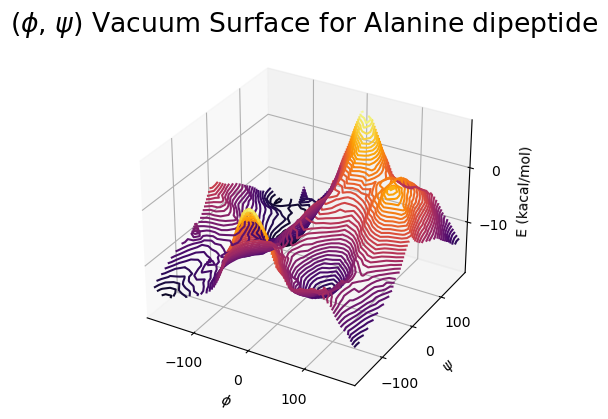

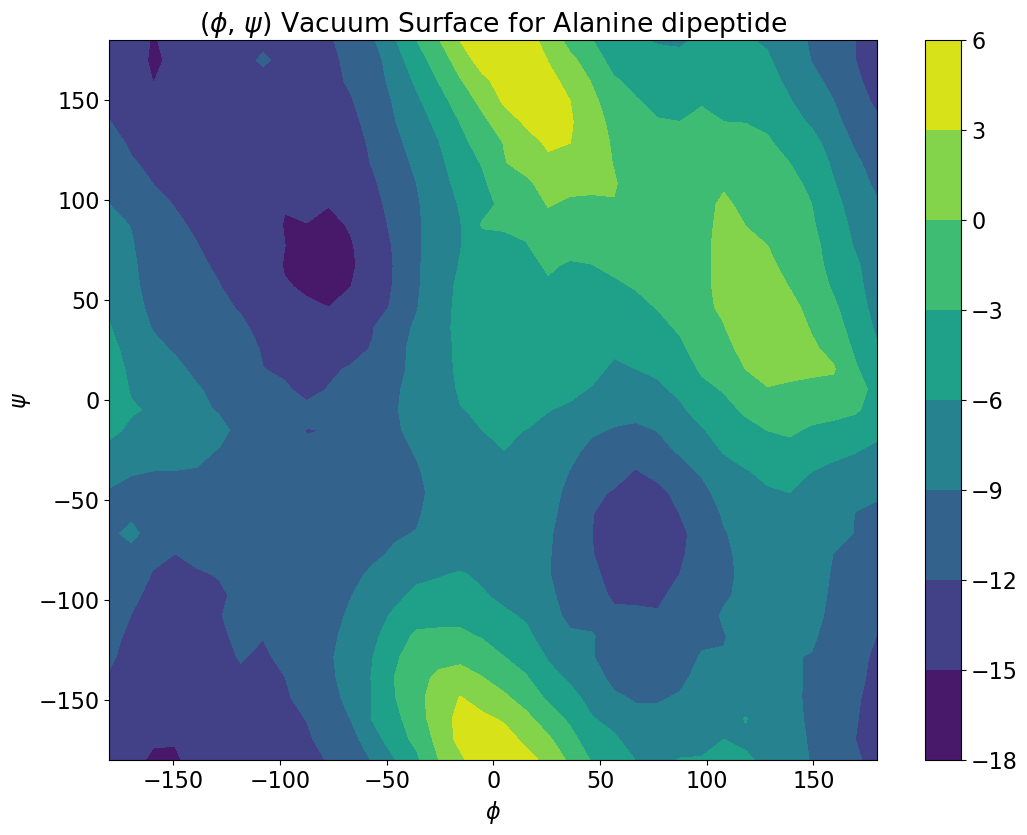

In [3]:
def pltFYMap():
    import pickle
    import pandas as pd
    import numpy as np
    if gbmv:
        with open('gbmv/fymap-ala_gbmv.pkl', 'rb') as fh:
            fymap = pickle.load(fh)
    else:
        with open('vacuum/fymap-ala.pkl', 'rb') as fh:
            fymap = pickle.load(fh)

    en_df = pd.DataFrame.from_dict(fymap)
    en_df.sort_values(by=['F','Y'],inplace=True)
    fymap = en_df.to_dict(orient='list')
    F = np.linspace(-180,180,36)
    Y = F
    # reshape the energy array into nxn array
    # use transpose (.T) because of loop order above
    ener = np.reshape(np.asarray(fymap['ener']),(len(F),len(Y)))
    ener = ener.T
    emax = np.max(ener)
    emin = np.min(ener)
    erange = emax - emin
    ehigh = np.ceil(emin+1.1*erange)
    elow = np.floor(emax-1.1*erange)
    F,Y=np.meshgrid(F,Y)
    # Now let's plot the data f/y map
    from mpl_toolkits.mplot3d import axes3d
    import matplotlib.pyplot as plt
    from matplotlib import cm
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    plt.rcParams.update({'font.size':16})
    # Plot the 3D surface
    ax.contour3D(F,Y,ener,50,cmap='inferno')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_zlim(elow, ehigh)
    
    if gbmv: ax.set_title('($\phi$, $\psi$) GBMV Surface for Alanine dipeptide')
    else: ax.set_title('($\phi$, $\psi$) Vacuum Surface for Alanine dipeptide')
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$\psi$')
    ax.set_zlabel('E (kacal/mol)')
    if gbmv: plt.savefig('gbmv/fysurf-ala_gbmv.pdf')    
    else: plt.savefig('vacuum/fysurf-ala.pdf')    
    plt.show()
    fig = plt.figure(figsize=(12,9))
    left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
    ax = fig.add_axes([left, bottom, width, height]) 
    cp = plt.contourf(F, Y, ener)
    plt.colorbar(cp) 
    if gbmv: ax.set_title('($\phi$, $\psi$) GBMV Surface for Alanine dipeptide')
    else: ax.set_title('($\phi$, $\psi$) Vacuum Surface for Alanine dipeptide')
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$\psi$')
    if gbmv: plt.savefig('gbmv/fycontour-ala_gbmv.pdf')
    else: plt.savefig('vacuum/fycontour-ala.pdf')
    plt.show()
    return
gbmv = False
pltFYMap()